In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV

five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]
sns.set_palette(five_thirty_eight)


In [2]:
df2 = pd.read_csv('C:\\Users\\John\\Documents\\notGitHub\\trip_csv\\trippub.csv')
df2 = df2[df2.HH_CBSA != "XXXXX"]
df2['HH_CBSA'] = df2.HH_CBSA.astype(int)
df2 = df2[df2['HH_CBSA'] == 47900]

df2['TRPTRANS'] = df2.TRPTRANS.astype(int)
df2['local_rail'] = (df2.TRPTRANS==16)
df2['drove'] = (df2.TRPTRANS==3)|(df2.TRPTRANS==
                4)|(df2.TRPTRANS==5)|(df2.TRPTRANS==
                6)|(df2.TRPTRANS==18)
df2.TRACC_WLK.value_counts()


-1    5621
 1     314
 2      66
Name: TRACC_WLK, dtype: int64

In [3]:
public = df2.PUBTRANS.value_counts()
walk_to = df2.TRACC_WLK.value_counts()
walk_from = df2.TREGR_WLK.value_counts()
drove_to = df2.TREGR_POV.value_counts()
drove_from = df2.TRACC_POV.value_counts()


public_frac = public[1]/(public[1]+public[2])
walk_to_p = walk_to[1]/(walk_to[1]+walk_to[2])
walk_from_p = walk_from[1]/(walk_from[1]+walk_from[2])
drove_to_p = drove_to[1]/(drove_to[1]+drove_to[2])
drove_from_p = drove_from[1]/(drove_from[1]+drove_from[2])

print('Trips using public transit: ', "{0:.2f}%".format(public_frac*100))
print('Percent walking to transit: ', "{0:.2f}%".format(walk_to_p*100))
print('Percent walking from transit: ', "{0:.2f}%".format(walk_from_p*100))
print('Percent driving to transit: ', "{0:.2f}%".format(drove_to_p*100))
print('Percent driving from transit: ', "{0:.2f}%".format(drove_from_p*100))

Trips using public transit:  6.33%
Percent walking to transit:  82.63%
Percent walking from transit:  83.16%
Percent driving to transit:  6.58%
Percent driving from transit:  8.95%


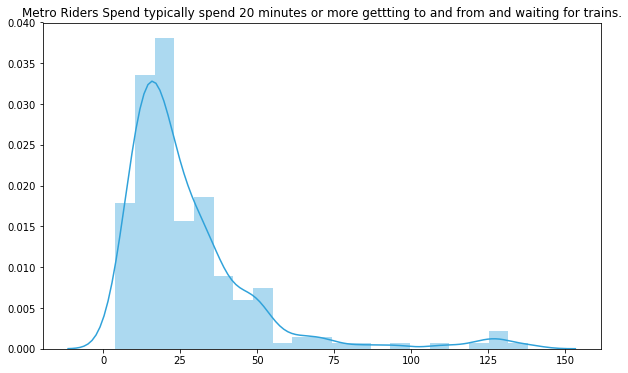

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(df2[df2.local_rail].TRACCTM+df2[df2.local_rail].TREGRTM+df2[df2.local_rail].TRWAITTM)

ax.set_title('Metro Riders Spend typically spend 20 minutes or more gettting to and from and waiting for trains.');
fig.savefig('Delays')

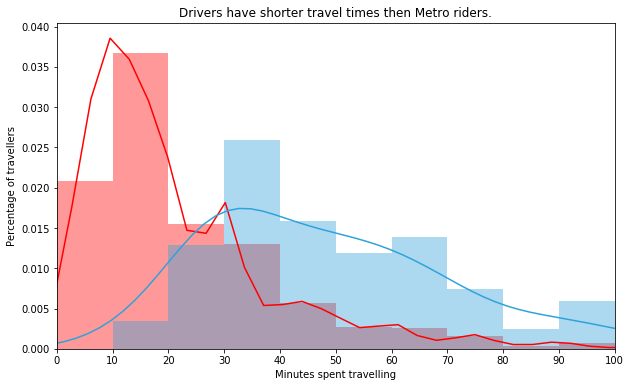

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))

bins = [0,10,20,30,40,50,60,70,80,90,100]

sns.distplot(df2[df2.drove].TRVLCMIN,
             bins=bins, ax=ax, norm_hist=True,color="red")
sns.distplot(df2[df2.local_rail].TRVLCMIN,
             bins=bins, ax=ax, norm_hist=True)

ax.set_title('Drivers have shorter travel times then Metro riders.')
ax.set_xlabel('Minutes spent travelling')
ax.set_ylabel('Percentage of travellers')
ax.set_xlim(0,100)
ax.set_xticks(bins);
fig.savefig('Travel times')

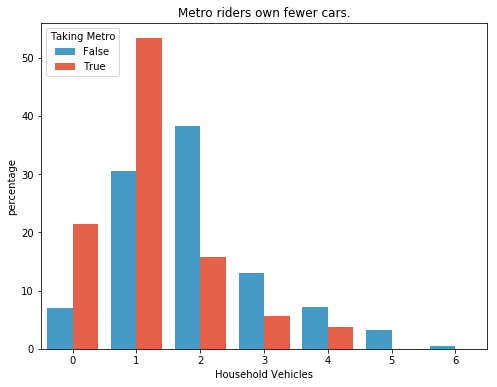

In [40]:
df2['Taking Metro'] = df2.local_rail
df2['Household Vehicles'] = df2.HHVEHCNT

fig, ax = plt.subplots(figsize=(8, 6))

vehicle_percentages = (df2.groupby(['Taking Metro'])['Household Vehicles']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('Household Vehicles'))

ax = sns.barplot(x="Household Vehicles", y="percentage", hue="Taking Metro",
                    data=vehicle_percentages)
ax.format_ydata
ax.set_xlim(-0.5,6.5)
ax.set_title('Metro riders own fewer cars.');
fig.savefig('Car_owners')

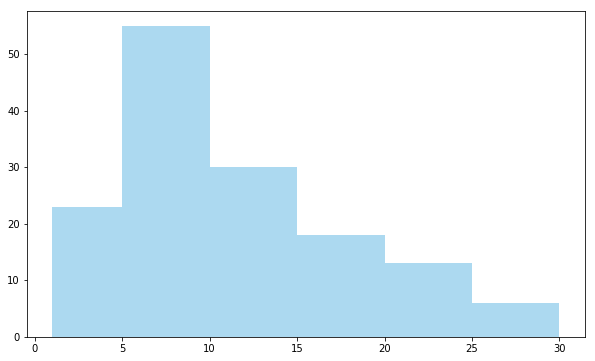

In [6]:
# I want to see if any member of the household ever walked to the metro in order to assess if it is in walking distance:
df2 = df2.replace({'TRACC_WLK':{2:0}})
df2[['TRACC_WLK', 'HOUSEID']].groupby('HOUSEID').max().TRACC_WLK.value_counts()
df2['walk_times'] = (df2.TRACCTM * df2.replace({'TRACC_WLK':{2:0, -1:0, -9:0}}).TRACC_WLK).dropna()
walk_times_max = df2[['walk_times', 'HOUSEID']].groupby('HOUSEID').max()
bins = [1,5,10,15,20,25,30]
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(walk_times_max, ax=ax, bins = bins, kde=False)

In [ ]:
df2.replace({'TREGR_WLK':{2:0, -1:0, -9:0}}).TREGR_WLK.value_counts()

In [ ]:
df2[['walk_times', 'HOUSEID']].groupby(['HOUSEID']).max().shape, df2.shape

In [11]:
# # repeating but from destination and using person id instead

df2 = df2.replace({'TREGR_WLK':{2:0}})
df2[['TREGR_WLK', 'HOUSEID', 'PERSONID']].groupby(['HOUSEID', 'PERSONID']).max().TREGR_WLK.value_counts()
df2['walk_times_after'] = (df2.TREGRTM * df2.replace({'TREGR_WLK':{2:0, -1:0, -9:0}}).TREGR_WLK)
walk_times_after_max = df2[['walk_times_after', 'HOUSEID', 'PERSONID']].groupby(['HOUSEID', 'PERSONID']).max()
# bins = [1,5,10,15,20,25,30]
# fig, ax = plt.subplots(figsize=(10, 6))
# sns.distplot(walk_times_after_max, ax=ax, bins = bins, kde=False)

In [12]:
walk_times_max.columns = ['max_walk_to']
walk_times_after_max.columns = ['max_walk_from']

In [13]:

df3 = df2.merge(walk_times_after_max.replace({'max_walk_from':{0:200}}).reset_index(), how='left').merge(
    walk_times_max.replace({'max_walk_to':{0:200}}).reset_index(), how='left')

In [14]:
df3[df3.drove].max_walk_from.describe()

count    4039.000000
mean      195.049765
std        30.356031
min         1.000000
25%       200.000000
50%       200.000000
75%       200.000000
max       200.000000
Name: max_walk_from, dtype: float64

In [43]:
df3['Within 10 minutes of transit'] = np.where(df3['max_walk_to']<10, 1, 0)
df3['Within 15 minutes of transit'] = np.where(df3['max_walk_to']<15, 1, 0)
df3['Within 30 minutes of transit'] = np.where(df3['max_walk_to']<30, 1, 0)
df3['Miles Traveled'] = pd.cut(df3.TRPMILES,4,labels=[1,2,3,4])
df3['Car Owner'] =  np.where(df3['HHVEHCNT']>0, 1, 0)
df3['Going to Work'] =  np.where(df3['TRIPPURP']=='HBW', 1, 0)

X = df3[['Miles Traveled', 'Within 15 minutes of transit', 'Car Owner', 'Going to Work']]
y = df3.local_rail

cv = StratifiedKFold(n_splits=5, shuffle=True)
dt = RandomForestClassifier(class_weight = 'balanced')
etc = ExtraTreesClassifier(class_weight = 'balanced')
bc = BaggingClassifier()
v1 = cross_val_score(dt, X, y, cv=cv, n_jobs=-1)
v2 = cross_val_score(etc, X, y, cv=cv, n_jobs=-1)
v3 = cross_val_score(bc, X, y, cv=cv, n_jobs=-1)
np.mean(v1), np.mean(v2), np.mean(v3)


(0.7822026089369969, 0.789868581737441, 0.9645058284762698)

In [44]:

hyper_parameters = {
             'n_estimators':range(10,50,10),
             'min_samples_split':range(2, 14, 3),
             'max_depth':range(2, 14, 4)
}

sherwood = GridSearchCV(dt, hyper_parameters, cv=5, verbose=1, n_jobs=-1)
mirkwood = GridSearchCV(bc, hyper_parameters, cv=5, verbose=1, n_jobs=-1)
avalon = GridSearchCV(etc, hyper_parameters, cv=5, verbose=1, n_jobs=-1)

sherwood.fit(X, y).best_params_, sherwood.fit(X, y).best_score_,
mirkwood.fit(X, y).best_params_, mirkwood.fit(X, y).best_score_,
avalon.fit(X, y).best_params_, avalon.fit(X, y).best_score_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 233 out of 240 | elapsed:   15.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   15.4s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   14.8s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
c:\programdata\anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
c:\programdata\anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x00000204900B5F60, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'c:\programdata\anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'c:\programdata\anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'c:\\programd...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x00000204900B5F60, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'c:\programdata\anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'c:\programdata\anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'c:\\programd...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
c:\programdata\anaconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
c:\programdata\anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
c:\programdata\anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
c:\programdata\anaconda3\lib\site-packages\tornado\platform\asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    107         except RuntimeError:
    108             old_loop = None
    109         try:
    110             self._setup_logging()
    111             asyncio.set_event_loop(self.asyncio_loop)
--> 112             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Win...EventLoop running=True closed=False debug=False>>
    113         finally:
    114             asyncio.set_event_loop(old_loop)
    115 
    116     def stop(self):

...........................................................................
c:\programdata\anaconda3\lib\asyncio\base_events.py in run_forever(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
    416             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    417                                    finalizer=self._asyncgen_finalizer_hook)
    418         try:
    419             events._set_running_loop(self)
    420             while True:
--> 421                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_Windo...EventLoop running=True closed=False debug=False>>
    422                 if self._stopping:
    423                     break
    424         finally:
    425             self._stopping = False

...........................................................................
c:\programdata\anaconda3\lib\asyncio\base_events.py in _run_once(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
   1426                         logger.warning('Executing %s took %.3f seconds',
   1427                                        _format_handle(handle), dt)
   1428                 finally:
   1429                     self._current_handle = None
   1430             else:
-> 1431                 handle._run()
        handle._run = <bound method Handle._run of <Handle IOLoop._run_callback(functools.par...02049813C268>))>>
   1432         handle = None  # Needed to break cycles when an exception occurs.
   1433 
   1434     def _set_coroutine_wrapper(self, enabled):
   1435         try:

...........................................................................
c:\programdata\anaconda3\lib\asyncio\events.py in _run(self=<Handle IOLoop._run_callback(functools.par...02049813C268>))>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method IOLoop._run_callback of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (functools.partial(<function wrap.<locals>.null_wrapper at 0x000002049813C268>),)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
c:\programdata\anaconda3\lib\site-packages\tornado\ioloop.py in _run_callback(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, callback=functools.partial(<function wrap.<locals>.null_wrapper at 0x000002049813C268>))
    755         """Runs a callback with error handling.
    756 
    757         For use in subclasses.
    758         """
    759         try:
--> 760             ret = callback()
        ret = undefined
        callback = functools.partial(<function wrap.<locals>.null_wrapper at 0x000002049813C268>)
    761             if ret is not None:
    762                 from tornado import gen
    763                 # Functions that return Futures typically swallow all
    764                 # exceptions and store them in the Future.  If a Future

...........................................................................
c:\programdata\anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ()
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
c:\programdata\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in <lambda>()
    531             return
    532 
    533         if state & self.socket.events:
    534             # events still exist that haven't been processed
    535             # explicitly schedule handling to avoid missing events due to edge-triggered FDs
--> 536             self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
    537 
    538     def _init_io_state(self):
    539         """initialize the ioloop event handler"""
    540         with stack_context.NullContext():

...........................................................................
c:\programdata\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=0)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
c:\programdata\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
c:\programdata\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
c:\programdata\anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
c:\programdata\anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
c:\programdata\anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "\nhyper_parameters = {\n             'n_estimators...(X, y).best_params_, avalon.fit(X, y).best_score_", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 10, 12, 23, 51, 283895, tzinfo=tzutc()), 'msg_id': 'fd4e749fc9693c4c3a6f0e9cf4e7361f', 'msg_type': 'execute_request', 'session': '86837547d5bdee8417c76cec032c8e30', 'username': '', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'fd4e749fc9693c4c3a6f0e9cf4e7361f', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'86837547d5bdee8417c76cec032c8e30']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "\nhyper_parameters = {\n             'n_estimators...(X, y).best_params_, avalon.fit(X, y).best_score_", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 10, 12, 23, 51, 283895, tzinfo=tzutc()), 'msg_id': 'fd4e749fc9693c4c3a6f0e9cf4e7361f', 'msg_type': 'execute_request', 'session': '86837547d5bdee8417c76cec032c8e30', 'username': '', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'fd4e749fc9693c4c3a6f0e9cf4e7361f', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
c:\programdata\anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'86837547d5bdee8417c76cec032c8e30'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "\nhyper_parameters = {\n             'n_estimators...(X, y).best_params_, avalon.fit(X, y).best_score_", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 10, 12, 23, 51, 283895, tzinfo=tzutc()), 'msg_id': 'fd4e749fc9693c4c3a6f0e9cf4e7361f', 'msg_type': 'execute_request', 'session': '86837547d5bdee8417c76cec032c8e30', 'username': '', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'fd4e749fc9693c4c3a6f0e9cf4e7361f', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
c:\programdata\anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="\nhyper_parameters = {\n             'n_estimators...(X, y).best_params_, avalon.fit(X, y).best_score_", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "\nhyper_parameters = {\n             'n_estimators...(X, y).best_params_, avalon.fit(X, y).best_score_"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
c:\programdata\anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("\nhyper_parameters = {\n             'n_estimators...(X, y).best_params_, avalon.fit(X, y).best_score_",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("\nhyper_parameters = {\n             'n_estimators...(X, y).best_params_, avalon.fit(X, y).best_score_",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
c:\programdata\anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="\nhyper_parameters = {\n             'n_estimators...(X, y).best_params_, avalon.fit(X, y).best_score_", store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
c:\programdata\anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-44-51c8de7a1b09>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 2049876b240, executio..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x0000020497BF8AE0, file "<ipython-input-44-51c8de7a1b09>", line 13>
        result = <ExecutionResult object at 2049876b240, executio..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
c:\programdata\anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x0000020497BF8AE0, file "<ipython-input-44-51c8de7a1b09>", line 13>, result=<ExecutionResult object at 2049876b240, executio..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x0000020497BF8AE0, file "<ipython-input-44-51c8de7a1b09>", line 13>
        self.user_global_ns = {'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import pandas as pd\nimport seaborn as sns\nimport...  "#8b8b8b",\n]\nsns.set_palette(five_thirty_eight)', "df2 = pd.read_csv('C:\\\\Users\\\\John\\\\Documents\\\\n...)|(df2.TRPTRANS==18)\ndf2.TRACC_WLK.value_counts()", 'public = df2.PUBTRANS.value_counts()\nwalk_to = d... transit: \', "{0:.2f}%".format(drove_from_p*100))', "fig, ax = plt.subplots(figsize=(10, 6))\nsns.dist...e gettting to and from and waiting for trains.');", "fig, ax = plt.subplots(figsize=(10, 6))\n\nbins = ...vellers')\nax.set_xlim(0,100)\nax.set_xticks(bins);", '# I want to see if any member of the household e...ot(walk_times_max, ax=ax, bins = bins, kde=False)', "df2.replace({'TREGR_WLK':{2:0, -1:0, -9:0}}).TREGR_WLK.value_counts()", "df2[['walk_times', 'HOUSEID']].groupby(['HOUSEID']).max().shape, df2.shape", '# # repeating but from destination and using per...k_times_after_max, ax=ax, bins = bins, kde=False)', "walk_times_max.columns = ['max_walk_to']\nwalk_times_after_max.columns = ['max_walk_from']", '# # repeating but from destination and using per...k_times_after_max, ax=ax, bins = bins, kde=False)', "walk_times_max.columns = ['max_walk_to']\nwalk_times_after_max.columns = ['max_walk_from']", "\ndf3 = df2.merge(walk_times_after_max.replace({'...max_walk_to':{0:200}}).reset_index(), how='left')", 'df3[df3.drove].max_walk_from.describe()', "df3['Within 10 minutes of transit'] = np.where(d...s = cross_val_score(dt, X, y, cv=cv, n_jobs=-1)\ns", "\nhyper_parameters = {\n             'n_estimators....fit(X, y)\n\nrobin.best_params_, robin.best_score_", "strengths = pd.DataFrame([np.array(X.columns.tol...engths.sort_values('Importance', ascending=False)", "df3['Taking Metro'] = df3.local_rail\ndf3['Househ...ders tend to come from houses with fewer cars.');", 'from sklearn.externals.six import StringIO\nfrom ...ph = f.read()\ndisplay(graphviz.Source(dot_graph))', ...], 'Out': {2: -1    5621
 1     314
 2      66
Name: TRACC_WLK, dtype: int64, 6: <matplotlib.axes._subplots.AxesSubplot object>, 7: 0    5685
1     316
Name: TREGR_WLK, dtype: int64, 8: ((771, 1), (6001, 105)), 14: count    4039.000000
mean      195.049765
std   ...   200.000000
Name: max_walk_from, dtype: float64, 15: array([0.7743547 , 0.76166667, 0.78      , 0.79916667, 0.74583333]), 16: ({'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 10}, 0.8186968838526912), 17:           Instrumental Variable   Importance
1  ...0817
0                Miles Traveled  0.000161762, 20: DecisionTreeClassifier(class_weight=None, criter..., random_state=None,
            splitter='best'), 21: <bound method BaseDecisionTree.decision_path of ... random_state=None,
            splitter='best')>, ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, 'StringIO': <class '_io.StringIO'>, 'X':      Miles Traveled  Within 15 minutes of transi...        0              0

[6001 rows x 4 columns], ...}
        self.user_ns = {'BaggingClassifier': <class 'sklearn.ensemble.bagging.BaggingClassifier'>, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import pandas as pd\nimport seaborn as sns\nimport...  "#8b8b8b",\n]\nsns.set_palette(five_thirty_eight)', "df2 = pd.read_csv('C:\\\\Users\\\\John\\\\Documents\\\\n...)|(df2.TRPTRANS==18)\ndf2.TRACC_WLK.value_counts()", 'public = df2.PUBTRANS.value_counts()\nwalk_to = d... transit: \', "{0:.2f}%".format(drove_from_p*100))', "fig, ax = plt.subplots(figsize=(10, 6))\nsns.dist...e gettting to and from and waiting for trains.');", "fig, ax = plt.subplots(figsize=(10, 6))\n\nbins = ...vellers')\nax.set_xlim(0,100)\nax.set_xticks(bins);", '# I want to see if any member of the household e...ot(walk_times_max, ax=ax, bins = bins, kde=False)', "df2.replace({'TREGR_WLK':{2:0, -1:0, -9:0}}).TREGR_WLK.value_counts()", "df2[['walk_times', 'HOUSEID']].groupby(['HOUSEID']).max().shape, df2.shape", '# # repeating but from destination and using per...k_times_after_max, ax=ax, bins = bins, kde=False)', "walk_times_max.columns = ['max_walk_to']\nwalk_times_after_max.columns = ['max_walk_from']", '# # repeating but from destination and using per...k_times_after_max, ax=ax, bins = bins, kde=False)', "walk_times_max.columns = ['max_walk_to']\nwalk_times_after_max.columns = ['max_walk_from']", "\ndf3 = df2.merge(walk_times_after_max.replace({'...max_walk_to':{0:200}}).reset_index(), how='left')", 'df3[df3.drove].max_walk_from.describe()', "df3['Within 10 minutes of transit'] = np.where(d...s = cross_val_score(dt, X, y, cv=cv, n_jobs=-1)\ns", "\nhyper_parameters = {\n             'n_estimators....fit(X, y)\n\nrobin.best_params_, robin.best_score_", "strengths = pd.DataFrame([np.array(X.columns.tol...engths.sort_values('Importance', ascending=False)", "df3['Taking Metro'] = df3.local_rail\ndf3['Househ...ders tend to come from houses with fewer cars.');", 'from sklearn.externals.six import StringIO\nfrom ...ph = f.read()\ndisplay(graphviz.Source(dot_graph))', ...], 'Out': {2: -1    5621
 1     314
 2      66
Name: TRACC_WLK, dtype: int64, 6: <matplotlib.axes._subplots.AxesSubplot object>, 7: 0    5685
1     316
Name: TREGR_WLK, dtype: int64, 8: ((771, 1), (6001, 105)), 14: count    4039.000000
mean      195.049765
std   ...   200.000000
Name: max_walk_from, dtype: float64, 15: array([0.7743547 , 0.76166667, 0.78      , 0.79916667, 0.74583333]), 16: ({'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 10}, 0.8186968838526912), 17:           Instrumental Variable   Importance
1  ...0817
0                Miles Traveled  0.000161762, 20: DecisionTreeClassifier(class_weight=None, criter..., random_state=None,
            splitter='best'), 21: <bound method BaseDecisionTree.decision_path of ... random_state=None,
            splitter='best')>, ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, 'StringIO': <class '_io.StringIO'>, 'X':      Miles Traveled  Within 15 minutes of transi...        0              0

[6001 rows x 4 columns], ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
C:\Users\John\Documents\GitHub\Capstone\<ipython-input-44-51c8de7a1b09> in <module>()
      8 sherwood = GridSearchCV(dt, hyper_parameters, cv=5, verbose=1, n_jobs=-1)
      9 mirkwood = GridSearchCV(bc, hyper_parameters, cv=5, verbose=1, n_jobs=-1)
     10 avalon = GridSearchCV(etc, hyper_parameters, cv=5, verbose=1, n_jobs=-1)
     11 
     12 sherwood.fit(X, y).best_params_, sherwood.fit(X, y).best_score_,
---> 13 mirkwood.fit(X, y).best_params_, mirkwood.fit(X, y).best_score_,
     14 avalon.fit(X, y).best_params_, avalon.fit(X, y).best_score_

...........................................................................
c:\programdata\anaconda3\lib\site-packages\sklearn\model_selection\_search.py in fit(self=GridSearchCV(cv=5, error_score='raise',
       e...ain_score='warn',
       scoring=None, verbose=1), X=     Miles Traveled  Within 15 minutes of transi...        0              0

[6001 rows x 4 columns], y=0       False
1       False
2       False
3     ...False
Name: local_rail, Length: 6001, dtype: bool, groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=5, random_state=None, shuffle=False)>
        X =      Miles Traveled  Within 15 minutes of transi...        0              0

[6001 rows x 4 columns]
        y = 0       False
1       False
2       False
3     ...False
Name: local_rail, Length: 6001, dtype: bool
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
c:\programdata\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Tue Apr 10 08:24:36 2018
PID: 8320                 Python 3.6.4: c:\programdata\anaconda3\python.exe
...........................................................................
c:\programdata\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (BaggingClassifier(base_estimator=None, bootstrap...state=None,
         verbose=0, warm_start=False),      Miles Traveled  Within 15 minutes of transi...        0              0

[6001 rows x 4 columns], 0       False
1       False
2       False
3     ...False
Name: local_rail, Length: 6001, dtype: bool, {'score': <function _passthrough_scorer>}, array([1194, 1195, 1196, ..., 5998, 5999, 6000]), array([   0,    1,    2, ..., 1611, 1612, 1795]), 1, {'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 10}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
c:\programdata\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (BaggingClassifier(base_estimator=None, bootstrap...state=None,
         verbose=0, warm_start=False),      Miles Traveled  Within 15 minutes of transi...        0              0

[6001 rows x 4 columns], 0       False
1       False
2       False
3     ...False
Name: local_rail, Length: 6001, dtype: bool, {'score': <function _passthrough_scorer>}, array([1194, 1195, 1196, ..., 5998, 5999, 6000]), array([   0,    1,    2, ..., 1611, 1612, 1795]), 1, {'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 10})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
c:\programdata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=BaggingClassifier(base_estimator=None, bootstrap...state=None,
         verbose=0, warm_start=False), X=     Miles Traveled  Within 15 minutes of transi...        0              0

[6001 rows x 4 columns], y=0       False
1       False
2       False
3     ...False
Name: local_rail, Length: 6001, dtype: bool, scorer={'score': <function _passthrough_scorer>}, train=array([1194, 1195, 1196, ..., 5998, 5999, 6000]), test=array([   0,    1,    2, ..., 1611, 1612, 1795]), verbose=1, parameters={'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 10}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    439                       for k, v in fit_params.items()])
    440 
    441     test_scores = {}
    442     train_scores = {}
    443     if parameters is not None:
--> 444         estimator.set_params(**parameters)
        estimator.set_params = <bound method BaseEstimator.set_params of Baggin...tate=None,
         verbose=0, warm_start=False)>
        parameters = {'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 10}
    445 
    446     start_time = time.time()
    447 
    448     X_train, y_train = _safe_split(estimator, X, y, train)

...........................................................................
c:\programdata\anaconda3\lib\site-packages\sklearn\base.py in set_params(self=BaggingClassifier(base_estimator=None, bootstrap...state=None,
         verbose=0, warm_start=False), **params={'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 10})
    269             key, delim, sub_key = key.partition('__')
    270             if key not in valid_params:
    271                 raise ValueError('Invalid parameter %s for estimator %s. '
    272                                  'Check the list of available parameters '
    273                                  'with `estimator.get_params().keys()`.' %
--> 274                                  (key, self))
        key = 'max_depth'
        self = BaggingClassifier(base_estimator=None, bootstrap...state=None,
         verbose=0, warm_start=False)
    275 
    276             if delim:
    277                 nested_params[key][sub_key] = value
    278             else:

ValueError: Invalid parameter max_depth for estimator BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.
___________________________________________________________________________

In [17]:
strengths = pd.DataFrame([np.array(X.columns.tolist()).T,robin.best_estimator_.feature_importances_]).T
strengths.columns = ['Instrumental Variable', 'Importance']
strengths.sort_values('Importance', ascending=False)

,Instrumental Variable,Importance
1,Within 15 minutes of transit,0.580554
3,Going to Work,0.386202
2,Car Owner,0.0330817
0,Miles Traveled,0.000161762
